# Eurovision Points Prediction Based on Song Characteristics


### Introduction

Every year, music fans around the world tune into the [Eurovision Song Contest](https://eurovision.tv/). Organized by the European Broadcasting Union and running since 1956, it's been billed as "one of the longest-running and most watched international song contests" [[1](#Ref1)]. The rules have changed over the years, but essentially each participating country (mostly European, but sometimes includes Israel, Australia, and others outside Europe) submits an original song, no more than 3 minutes long, to represent them. The audience and a panel of music industry judges from the other countries vote for their favourites. Points are awarded according to the vote. Competition can be fierce and national pride is on the line. Unlike other television competitions, Eurovision is surprisingly transparent and makes vote details public [[2](#Ref2)]. This project seeks to find a supervised learning model that predicts a song's points based on its characteristics.

### Data and Sources

Urun, Fernandes, and Bozsik [[3](#Ref3)] has compiled a dataset of Eurovision results and song characteristics from 1956 to 2019 and made it available through [their Github](https://github.com/robertbozsik/eurovision-songs-audio-features). This dataset will be used for training the model.

A test dataset was manually created from data gathered from various publicly available websites [[2](#Ref2)],[[4](#Ref4)] for the 2022 contest, which was won by Ukraine.

Because the training and test datasets are not from the same source, they will not share the exact same features. However, there is enough overlap in features for this experiment. The features are song characteristics that have been estimated through [Spotify's API for extracting audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features) and include the following [[5](#Ref5)]:

- __danceability__: "Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable."
- __energy__: "Measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity."
- __loudness__: "The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks."
- __tempo__: "Overall estimated tempo of a track in beats per minute (BPM)."
- __valence__: "Measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track."

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

### 1. Load Datasets


In [2]:
# Load training dataset and show summary
df_train = pd.read_csv('merged_table.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1322 non-null   int64  
 1   R/O               1322 non-null   int64  
 2   Year              1322 non-null   int64  
 3   Host_City         1322 non-null   object 
 4   Country           1322 non-null   object 
 5   Contestant        1322 non-null   object 
 6   Song              1322 non-null   object 
 7   Points            1322 non-null   object 
 8   Place             1322 non-null   object 
 9   uri               431 non-null    object 
 10  danceability      431 non-null    float64
 11  energy            431 non-null    float64
 12  key               431 non-null    float64
 13  loudness          431 non-null    float64
 14  mode              431 non-null    float64
 15  speechiness       431 non-null    float64
 16  acousticness      431 non-null    float64


In [3]:
# Load test dataset and show summary
df_test = pd.read_csv('2022_eurovision_grandfinal.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         40 non-null     object 
 1   Artist          40 non-null     object 
 2   Points          25 non-null     float64
 3   key name        40 non-null     object 
 4   key             40 non-null     int64  
 5   mode            40 non-null     int64  
 6   time_signature  40 non-null     int64  
 7   tempo           40 non-null     int64  
 8   loudness        40 non-null     float64
 9   energy          40 non-null     int64  
 10  positiveness    40 non-null     int64  
 11  danceability    40 non-null     int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 3.9+ KB


### 2. Training Dataset Cleaning and EDA

Because the training and test datasets are not from the same source, their features will have to be aligned to fit the same model. The training dataset will have to have some feature columns removed. Note also that the training dataset actually has a lot of gaps in the song characteristics. After cleaning, there are 414 observations available for training the model.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1322 non-null   int64  
 1   R/O               1322 non-null   int64  
 2   Year              1322 non-null   int64  
 3   Host_City         1322 non-null   object 
 4   Country           1322 non-null   object 
 5   Contestant        1322 non-null   object 
 6   Song              1322 non-null   object 
 7   Points            1322 non-null   object 
 8   Place             1322 non-null   object 
 9   uri               431 non-null    object 
 10  danceability      431 non-null    float64
 11  energy            431 non-null    float64
 12  key               431 non-null    float64
 13  loudness          431 non-null    float64
 14  mode              431 non-null    float64
 15  speechiness       431 non-null    float64
 16  acousticness      431 non-null    float64


In [5]:
# Remove columns that will not be applicable in the model
features_to_drop = ['R/O',
                    'Year',
                    'Host_City',
                    'Country',
                    'Contestant',
                    'Song',
                    'Place',
                    'uri',
                    'speechiness',
                    'acousticness',
                    'instrumentalness',
                    'liveness',
                    'duration_ms']
df_train.drop(features_to_drop, axis=1, inplace=True)
df_train.drop(columns=df_train.columns[0], axis=1, inplace=True) # Also remove unnammed column

# Show summary of training dataset for model development
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Points          1322 non-null   object 
 1   danceability    431 non-null    float64
 2   energy          431 non-null    float64
 3   key             431 non-null    float64
 4   loudness        431 non-null    float64
 5   mode            431 non-null    float64
 6   valence         431 non-null    float64
 7   tempo           431 non-null    float64
 8   time_signature  431 non-null    float64
dtypes: float64(8), object(1)
memory usage: 93.1+ KB


In [6]:
# Remove rows that do not have observations that can be used in the model
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 431 entries, 0 to 1321
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Points          431 non-null    object 
 1   danceability    431 non-null    float64
 2   energy          431 non-null    float64
 3   key             431 non-null    float64
 4   loudness        431 non-null    float64
 5   mode            431 non-null    float64
 6   valence         431 non-null    float64
 7   tempo           431 non-null    float64
 8   time_signature  431 non-null    float64
dtypes: float64(8), object(1)
memory usage: 33.7+ KB


In [7]:
# Column 'Points' is an object but should be numeric
df_train['Points'] = pd.to_numeric(df_train['Points'], errors='coerce')

# Check for nulls or bad data
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in df_train.columns:
    string_null = np.array([x in a[2:] for x in df_train[c]])
    print("Column:", c, "Null sum:", df_train[c].isnull().sum(), "String nulls:", string_null.sum())

Column: Points Null sum: 17 String nulls: 0
Column: danceability Null sum: 0 String nulls: 0
Column: energy Null sum: 0 String nulls: 0
Column: key Null sum: 0 String nulls: 0
Column: loudness Null sum: 0 String nulls: 0
Column: mode Null sum: 0 String nulls: 0
Column: valence Null sum: 0 String nulls: 0
Column: tempo Null sum: 0 String nulls: 0
Column: time_signature Null sum: 0 String nulls: 0


In [8]:
# There are 17 nulls in 'Points' which is approximately 4% of the 431 good observations
# So remove the corresponding rows
df_train.dropna(inplace=True)

# Check for nulls or bad data
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in df_train.columns:
    string_null = np.array([x in a[2:] for x in df_train[c]])
    print("Column:", c, "Null sum:", df_train[c].isnull().sum(), "String nulls:", string_null.sum())

df_train.info()

Column: Points Null sum: 0 String nulls: 0
Column: danceability Null sum: 0 String nulls: 0
Column: energy Null sum: 0 String nulls: 0
Column: key Null sum: 0 String nulls: 0
Column: loudness Null sum: 0 String nulls: 0
Column: mode Null sum: 0 String nulls: 0
Column: valence Null sum: 0 String nulls: 0
Column: tempo Null sum: 0 String nulls: 0
Column: time_signature Null sum: 0 String nulls: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 1303
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Points          414 non-null    float64
 1   danceability    414 non-null    float64
 2   energy          414 non-null    float64
 3   key             414 non-null    float64
 4   loudness        414 non-null    float64
 5   mode            414 non-null    float64
 6   valence         414 non-null    float64
 7   tempo           414 non-null    float64
 8   time_signature  414 non-null    float64
dt

Some song features may not actually be very helpful in the model as there may be very limited unique values. Time and key signatures are suspect because there are only so many that a songwriter would choose from. Note that the feature 'mode' is related to the key as Spotify uses it to denote whether the key is major or minor; hence 'mode' is suspect as well.

In [9]:
print('time_signature unique values:', df_train['time_signature'].unique())
print('key unique values:', df_train['key'].unique())
print('mode unique values:', df_train['mode'].unique())

time_signature unique values: [4. 3. 5. 1.]
key unique values: [10.  1.  9.  0.  8.  4.  6.  3. 11.  2.  5.  7.]
mode unique values: [0. 1.]


The correlation matrix, as visualized in a heat map, shows some decent amount of correlation between:
- 'loudness' and 'energy', 0.69 (Perhaps one needs more energy to sing louder?)
- 'valence' and 'danceability', 0.58 ("Valence" being Spotify's way of saying "positivity", so perhaps no one wishes to dance to a negative song?)
- 'valence' and 'energy', 0.51 (Perhaps it takes more energy to be positive?)

Interestingly, 'tempo' is not highly correlated with 'energy' and is negatively correlated with 'danceability'. So a faster song does not necessarily make it more energetic or danceable.

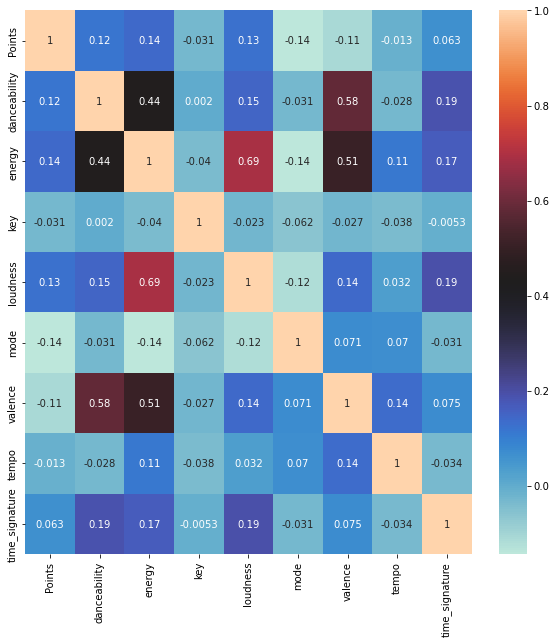

In [10]:
# Plot correlation matrix of features vs. points
corr_matrix = df_train.corr()

plt.figure(figsize=(10,10))
corr_heatmap = sns.heatmap(corr_matrix, cmap='icefire', annot=True)

The pair plot confirms the above suspicion that the features 'time_signature', 'key', and 'mode' will not be very helpful and can be excluded from the model development. Also, there does seem to be some correlation between 'energy' and 'loudness' although it may only be very weak.

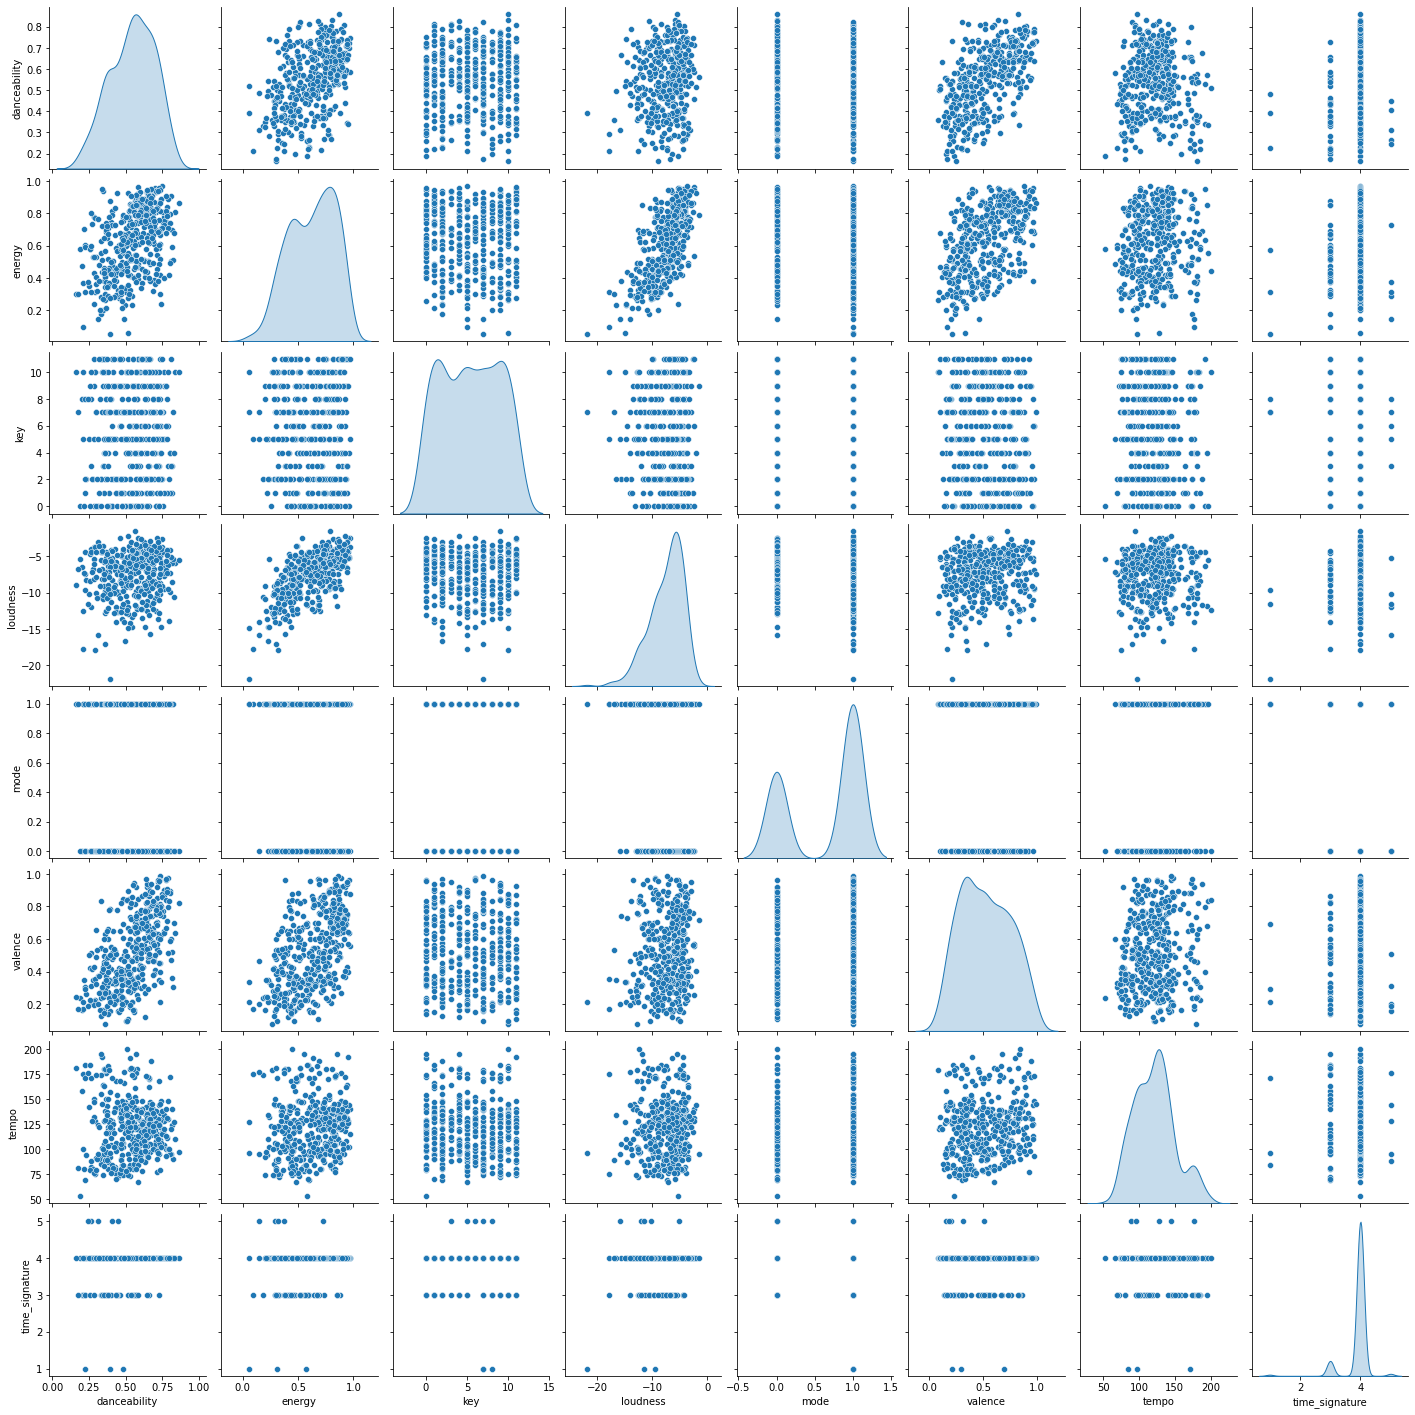

In [11]:
# Plot pair plot of features
pair_plot = sns.pairplot(df_train,
                         vars=['danceability', 'energy', 'key', 'loudness', 'mode', 'valence', 'tempo', 'time_signature'],
                         diag_kind="kde")

In [12]:
# Remove more columns that will not be helpful in model
features_to_drop = ['time_signature', 'key', 'mode']
df_train.drop(features_to_drop, axis=1, inplace=True)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 1303
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Points        414 non-null    float64
 1   danceability  414 non-null    float64
 2   energy        414 non-null    float64
 3   loudness      414 non-null    float64
 4   valence       414 non-null    float64
 5   tempo         414 non-null    float64
dtypes: float64(6)
memory usage: 22.6 KB


### 3. Model Training

A regression model will be developed to predict the number of points according to a best combination of features. The approach includes experimenting with polynomial regression and with forward stepwise multilinear regression. The R-squared values obtained from polynomial regression and multilinear regression informs the best model, which will be hand-tuned to include best features.

In [13]:
features = []
for c in df_train:
    features.append(c)
features.remove('Points')
print("Features for regression:", features)

Features for regression: ['danceability', 'energy', 'loudness', 'valence', 'tempo']


#### Polynomial Regression

Experiment with polynomial regression of each feature, trying up to degree 10 only. Note that degree 1 is the simple linear regression by default.

In [14]:
features_poly = features

In [15]:
formulastring = 'Points~'
adjr2_poly = pd.DataFrame({'degree':[1,2,3,4,5,6,7,8,9,10]})

for c in features_poly:
    i = 1
    poly_rsquared_adj = []
    for n in range(1,11):
        while i < n+1:
            addstring = '+ np.power('+ c + ',' + str(i) + ')'
            formulastring = formulastring + addstring
            i = i+1
        model_poly = smf.ols(formula=formulastring, data=df_train).fit()
        poly_rsquared_adj.append(model_poly.rsquared_adj)
    poly_rsquared_adj_df = pd.DataFrame({c:poly_rsquared_adj})
#    print(poly_rsquared_adj_df)
    adjr2_poly = adjr2_poly.join(poly_rsquared_adj_df, how='left')

adjr2_poly

,degree,danceability,energy,loudness,valence,tempo
0,1,0.010993,0.038551,0.100554,0.137963,0.138349
1,2,0.012288,0.037305,0.106706,0.138022,0.137108
2,3,0.011432,0.050752,0.105622,0.138303,0.136772
3,4,0.013256,0.048546,0.105760,0.136502,0.134845
4,5,0.013113,0.050251,0.105913,0.137332,0.132548
5,6,0.020038,0.047929,0.109644,0.137799,0.131516
6,7,0.023829,0.063435,0.096025,0.138218,0.053058
7,8,0.030878,0.065648,0.086805,0.138279,0.054359
8,9,0.028520,0.068316,0.083682,0.138464,0.037880
9,10,0.026696,0.095538,0.077673,0.140490,0.037228


#### Multilinear Regression

Experiment with forward stepwise selection of features without replacement. One best feature, of degree 1 (ie. no polynomial regression), will be added to the model at a time for each step _k_.

In [16]:
features_multi = features

In [17]:
# Step k = 1
best = ['',0]

for c in features_multi:
    model_multi = smf.ols(formula='Points~'+c,
                          data=df_train
                         ).fit()
    if model_multi.rsquared > best[1]:
        best = [c, model_multi.rsquared]

print("Best feature for step 1:", best[0], "R-squared:", best[1])
        
multi_feature_1 = best[0] # save best feature from this k = 1 step
model_multi_1 = smf.ols(formula='Points~'+multi_feature_1,
                        data=df_train
                       ).fit()
features_multi.remove(multi_feature_1) # prevent best feature used in this k = 1 step from being used again

Best feature for step 1: energy R-squared: 0.019071370475299387


In [18]:
# Step k = 2
best = ['',0]

for c in features_multi:
    model_multi = smf.ols(formula='Points~'+multi_feature_1+'+'+c,
                          data=df_train
                         ).fit()
    if model_multi.rsquared > best[1]:
        best = [c, model_multi.rsquared]

print("Best feature for step 2:", best[0], "R-squared:", best[1])
        
multi_feature_2 = best[0] # save best feature from this k = 2 step
model_multi_2 = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2,
                        data=df_train
                       ).fit()
features_multi.remove(multi_feature_2) # prevent best feature used in this k = 2 step from being used again

Best feature for step 2: valence R-squared: 0.06280285425155208


In [19]:
# Step k = 3
best = ['',0]

for c in features_multi:
    model_multi = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2+'+'+c,
                          data=df_train
                         ).fit()
    if model_multi.rsquared > best[1]:
        best = [c, model_multi.rsquared]

print("Best feature for step 3:", best[0], "R-squared:", best[1])
        
multi_feature_3 = best[0] # save best feature from this k = 3 step
model_multi_3 = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2+'+'+multi_feature_3,
                        data=df_train
                       ).fit()
features_multi.remove(multi_feature_3) # prevent best feature used in this k = 3 step from being used again

Best feature for step 3: danceability R-squared: 0.09424977719483785


In [20]:
# Step k = 4
best = ['',0]

for c in features_multi:
    model_multi = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2+'+'+multi_feature_3+'+'+c,
                          data=df_train
                         ).fit()
    if model_multi.rsquared > best[1]:
        best = [c, model_multi.rsquared]

print("Best feature for step 4:", best[0], "R-squared:", best[1])
        
multi_feature_4 = best[0] # save best feature from this k = 4 step
model_multi_4 = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2+'+'+multi_feature_3+'+'+multi_feature_4,
                        data=df_train
                       ).fit()
features_multi.remove(multi_feature_4) # prevent best feature used in this k = 4 step from being used again

Best feature for step 4: tempo R-squared: 0.09453834758244395


In [21]:
# Step k = 5
best = ['',0]

for c in features_multi:
    model_multi = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2+'+'+multi_feature_3+'+'+multi_feature_4+'+'+c,
                          data=df_train
                         ).fit()
    if model_multi.rsquared > best[1]:
        best = [c, model_multi.rsquared]

print("Best feature for step 5:", best[0], "R-squared:", best[1])
        
multi_feature_5 = best[0] # save best feature from this k = 5 step
model_multi_5 = smf.ols(formula='Points~'+multi_feature_1+'+'+multi_feature_2+'+'+multi_feature_3+'+'+multi_feature_4+'+'+multi_feature_5,
                        data=df_train
                       ).fit()
features_multi.remove(multi_feature_5) # prevent best feature used in this k = 5 step from being used again

Best feature for step 5: loudness R-squared: 0.09463142485569864


In [22]:
adjr2_multi = pd.DataFrame({"Add feature":[multi_feature_1, multi_feature_2, multi_feature_3, multi_feature_4, multi_feature_5],
                            "Adjusted R-squared":[model_multi_1.rsquared_adj,
                                                  model_multi_2.rsquared_adj,
                                                  model_multi_3.rsquared_adj,
                                                  model_multi_4.rsquared_adj,
                                                  model_multi_5.rsquared_adj]})
adjr2_multi

,Add feature,Adjusted R-squared
0,energy,0.016690
1,valence,0.058242
2,danceability,0.087622
3,tempo,0.085683
4,loudness,0.083536


#### Tuning Final Model

Based on the adjusted R-squared values found above for various trials of polynomial regression and multilinear regression, the final best model can be hand-tuned to include the combination of features that maximizes R-squared and maintains significant p-values (<0.025). The best model, as shown in the code and results summary below, turns out to be a combination of the features 'energy', 'danceability', and 'valence', with no intercept value.
<br>
<br>
<center>$Points = \beta_{0}(energy) + \beta_{1}(danceability) + \beta_{2}(valence)^2$</center>

In [23]:
model_best = smf.ols(formula='Points ~ energy + danceability + np.power(valence,2) -1', data=df_train).fit()
model_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Points   R-squared (uncentered):                   0.497
Model:                            OLS   Adj. R-squared (uncentered):              0.493
Method:                 Least Squares   F-statistic:                              135.2
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                    6.09e-61
Time:                        15:04:06   Log-Likelihood:                         -2493.8
No. Observations:                 414   AIC:                                      4994.
Df Residuals:                     411   BIC:                                      5006.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
energy                  98.7112     25.008      3.947      0.000      49.551     147.871
danceability           138.3112     30.012      4.609      0.000      79.315     197.307
np.power(valence, 2)  -128.9795     23.645     -5.455      0.000    -175.460     -82.499
==============================================================================
Omnibus:                      251.912   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2194.924
Skew:                           2.528   Prob(JB):                         0.00
Kurtosis:                      13.084   Cond. No.                         7.06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
# Model coefficients
coef_energy = 98.7112
coef_danceability = 138.3112
coef_valence = -128.9795

### 4. Test Dataset Cleaning

Results from Eurovision 2022 were used as a test dataset. Initially, 40 countries entered the contest and after two semi-final rounds, 25 moved to the final where points were obtained. Hence, after cleaning, there will be 25 observations available for testing the model.

The features 'time_signature', 'key', and 'mode' were deemed to not be helpful in the training model and so are also excluded from the test dataset.

For the features 'energy', 'positiveness', and 'danceability', the values were given by the data source in percent and so will need to be converted to a number in the range of 0 to 1 to match the values in the training dataset. Furthermore, 'positiveness' is actually the feature 'valence' so the column will need to be renamed.

Unlike for the training dataset, the test dataset will keep the 'Country' column for ease of later discussion.

In [25]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         40 non-null     object 
 1   Artist          40 non-null     object 
 2   Points          25 non-null     float64
 3   key name        40 non-null     object 
 4   key             40 non-null     int64  
 5   mode            40 non-null     int64  
 6   time_signature  40 non-null     int64  
 7   tempo           40 non-null     int64  
 8   loudness        40 non-null     float64
 9   energy          40 non-null     int64  
 10  positiveness    40 non-null     int64  
 11  danceability    40 non-null     int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 3.9+ KB


In [26]:
# Remove columns that will not be applicable for testing
features_to_drop = ['Artist',
                    'key name',
                    'key',
                    'mode',
                    'time_signature']
df_test.drop(features_to_drop, axis=1, inplace=True)
df_test.rename(columns={'positiveness':'valence'}, inplace=True)

# Show summary of test dataset for model testing
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       40 non-null     object 
 1   Points        25 non-null     float64
 2   tempo         40 non-null     int64  
 3   loudness      40 non-null     float64
 4   energy        40 non-null     int64  
 5   valence       40 non-null     int64  
 6   danceability  40 non-null     int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 2.3+ KB


In [27]:
# Remove rows that do not have observations that do not have a y_test to compare to
df_test.dropna(inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       25 non-null     object 
 1   Points        25 non-null     float64
 2   tempo         25 non-null     int64  
 3   loudness      25 non-null     float64
 4   energy        25 non-null     int64  
 5   valence       25 non-null     int64  
 6   danceability  25 non-null     int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.6+ KB


In [28]:
# Check for nulls or bad data
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
for c in df_test.columns:
    string_null = np.array([x in a[2:] for x in df_test[c]])
    print("Column:", c, "Null sum:", df_test[c].isnull().sum(), "String nulls:", string_null.sum())

Column: Country Null sum: 0 String nulls: 0
Column: Points Null sum: 0 String nulls: 0
Column: tempo Null sum: 0 String nulls: 0
Column: loudness Null sum: 0 String nulls: 0
Column: energy Null sum: 0 String nulls: 0
Column: valence Null sum: 0 String nulls: 0
Column: danceability Null sum: 0 String nulls: 0


In [29]:
# Columns energy, valence, danceability need to be transformed to the range 0 to 1 to match training dataset
df_test.rename(columns={'energy':'energy_old'}, inplace=True)
df_test['energy'] = df_test['energy_old']/100
df_test.drop('energy_old', axis=1, inplace=True)

df_test.rename(columns={'valence':'valence_old'}, inplace=True)
df_test['valence'] = df_test['valence_old']/100
df_test.drop('valence_old', axis=1, inplace=True)

df_test.rename(columns={'danceability':'danceability_old'}, inplace=True)
df_test['danceability'] = df_test['danceability_old']/100
df_test.drop('danceability_old', axis=1, inplace=True)

### 5. Model Testing

Apply the model to the test dataset!

In [30]:
points_test = []
i = 0
n = len(df_test)
while i < n:
    calc = round(coef_energy * df_test['energy'].iloc[i] + coef_danceability * df_test['danceability'].iloc[i] + coef_valence * pow(df_test['valence'].iloc[i],2))
    points_test.append(calc)
    i = i + 1

df_predict_points = pd.DataFrame({"Predict_Points":points_test})

df_result = df_test.join(df_predict_points, how='left')
df_result

,Country,Points,tempo,loudness,energy,valence,danceability,Predict_Points
0,Ukraine,631.0,105,-5.18,0.82,0.32,0.83,183
1,Armenia,61.0,170,-8.21,0.64,0.52,0.56,106
2,Australia,125.0,128,-10.44,0.43,0.38,0.36,74
3,Azerbaijan,106.0,79,-9.79,0.30,0.30,0.34,65
4,Belgium,64.0,144,-6.27,0.53,0.28,0.63,129
5,Czech Republic,38.0,126,-6.46,0.79,0.52,0.59,125
6,Estonia,141.0,123,-4.79,0.79,0.58,0.52,107
7,Finland,38.0,116,-4.11,0.87,0.49,0.50,124
8,France,17.0,120,-7.44,0.84,0.48,0.75,157
9,Germany,6.0,81,-6.43,0.64,0.52,0.65,118


### Results and Discussion

The adjusted R-squared for the hand-tuned best prediction model is 0.493 and so expectations were not very high!

It was surprising that the model predicted that Ukraine's song would result in the highest points (though the prediction was still significantly off). However, France's song which scored a measly 17 points (and second last) in real life would have resulted in 157 points (and second place!) if the model had its way. Overall, the model was not very consistent which was as expected.

It is possible that the main reason why the model did not perform well is because the features picked to train the model may not be the most representative of the predicted result. Indeed, this project attempted to fit song characteristics into an audience response, but it can not take into account the behaviour or intent of the audience. If the actual results were truly blind to all other influences, that is, if the audience were only allowed to vote based on song characteristics, then the model should inherently be more accurate. A possible solution may also be to add other features to the model that are unrelated to song characteristics but more descriptive of other factors such as the audience.

It is also possible that regression may not be the best approach for this problem. This project attempted to predict points, which is an unbounded quantity. An alternative may be to predict a ranking instead. However, rankings may also be handicapped by the same reasons.


### Conclusion

This project sought to find a supervised learning model that predicted a Eurovision song entry's points based on its characteristics using prior years' contest dataset. Polynomial regression and multilinear regression models were experimented with to inform a hand-tuned best prediction model which included a combination of three features in a multivariate regression model with marginal error. The model was then tested with a dataset which was not used in training and produced inconsistent results.



### References

<a id="Ref1"></a>[1] M. Mihalka, "Eurovision Song Contest," in _Music in World Cultures_. [Online]. Available: https://uark.pressbooks.pub/musicinworldcultures/chapter/eurovision-song-contest/

<a id="Ref2"></a>[2] "Eurovision Archives." Eurovision Song Contest. https://eurovision.tv/history (accessed Mar. 2, 2023).

<a id="Ref3"></a>[3] Ş. Urun, J. Fernandes, and R. Bozsik. "Audio Features of Songs in the Eurovision Song Contest." https://github.com/robertbozsik/eurovision-songs-audio-features (accessed Mar. 3, 2023).

<a id="Ref4"></a>[4] "Eurovision 2022 Track Analysis from Spotify." TellyStats. https://tellystats.com/Eurovision2022/TrackAnalysis (accessed Mar. 3, 2023).

<a id="Ref5"></a>[5] "Get Tracks' Audio Features." Spotify for Developers. https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features (accessed Mar. 3, 2023).

Code Credit: Portions of code were provided in the course labs by the Instructors and adapted for this project.